# Introduction
This notebook will walk you through  a  machine learning task of predicting output variable(s) starting with CSV data in the context of Electronic Design Automation (EDA). The problem statement is to predict net capacitance given pre-layout net features like number of MOS devices connected, total width etc. Please refer to "B. Shook, P. Bhansali, C. Kashyap, C. Amin and S. Joshi, MLParest: Machine Learning based Parasitic Estimation for Custom Circuit Design, 2020 57th ACM/IEEE Design Automation Conference (DAC), 2020, pp. 1-6, doi: 10.1109/DAC18072.2020.9218495" for more details on the problem statement. The outline of this Jupyter notebook is as follows:
<ol>
<li> Look at the bigger picture </li>
<li> Get the data  </li>
<li> Visualize and gain insights </li>
<li> Prepare the data for machine learning  </li>
<li> Select a model and train  </li>
<li> Fine tune the model </li>
<li> Present the solution  </li>
<li> Save the model </li> 
</ol>

## Problem Statement 
Given past net capacitances values from layout and extraction, build a model which can predict net capacitance within a "reasonable" accuracy. Having such a model can potentially help you shorter the expensive pre-polo iterations during a circuit design phase. We forumlate this problem as a regression task.


### Import Libraries

In [43]:
# NumPy and Pandas and other generics
import pandas as pd
import numpy as np
import sys
import random

In [44]:
# SKLEARN libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV

In [45]:
import sklearn 
print(f"Versions: sklearn = {sklearn.__version__}, pandas = {pd.__version__}, numpy = {np.__version__}, python = {sys.version.split()[0]}")


Versions: sklearn = 0.24.2, pandas = 1.2.5, numpy = 1.19.5, python = 3.7.3


In [46]:
# Visualization
import matplotlib.pyplot as plt

In [47]:
import warnings


In [48]:
# Maintain a static random seed for reproducibility
random.seed(7)

In [49]:
# customize matplotlib
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [50]:
warnings.filterwarnings("ignore")

## Get the Data
###### Note: For the purposes of this notebook, we have normalized the data and named the features columns as f1,f2,f3, etc... for protecting our company's IP.
If you want to predict housing price, upload housing prices with other house features. If you want to predict circuit performace, upload circuit performance data with circuit characterisitics. For parasitic estimation, we have collected data for each net. Each of the features f1, f2 ... represents normalized cap value (our target variable) and net characteristics (features) like total number of MOS devices connected, width of MOS devices, etc.


In [51]:
# read the CSV data into "df"
df = pd.read_csv("net_features_and_net_cap.csv")

## Visualize and gain insights
See columns, number of sample points and may be find out dirty-data.

In [10]:
# print a few elements in the dataframe
df.head()

,cap,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22
0,0.077530,0.023840,1,0.014869,0.006585,0.009917,0.0,0.000000,0.000000,0.016164,...,0.025862,0.000000,0.0,0.000000,0.0,0.0,0.0,0.023698,0.023698,0.020043
1,0.022282,0.007805,0,0.001952,0.000878,0.001322,0.0,0.003586,0.001870,0.001616,...,0.006466,0.009021,0.0,0.004187,0.0,0.0,0.0,0.007805,0.007805,0.006681
2,0.049999,0.023698,0,0.005926,0.002634,0.003967,0.0,0.010758,0.005609,0.004849,...,0.019397,0.027062,0.0,0.012560,0.0,0.0,0.0,0.023698,0.023698,0.020043
3,0.151557,0.072229,0,0.018063,0.007902,0.012149,0.0,0.032275,0.016827,0.014778,...,0.059113,0.081186,0.0,0.037679,0.0,0.0,0.0,0.072229,0.072229,0.060845
4,0.136290,0.054491,1,0.013592,0.005926,0.009174,0.0,0.098361,0.051282,0.000000,...,0.000000,0.247423,0.0,0.114833,0.0,0.0,0.0,0.054349,0.054349,0.045812


## Get Data Information

Some of the data may be missing, some data may be of numerical type, some data might be of "object" type.
###### Question: Do you think you can infer some of the data to be missing based on the information below? 
###### Question: How do you plan to deal with missing data if there is any? (Data imputation?)

In [11]:
# info() method prints information about a DataFrame like non-null values and memory usage.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137505 entries, 0 to 137504
Data columns (total 23 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cap     137505 non-null  float64
 1   f1      137505 non-null  float64
 2   f2      137505 non-null  int64  
 3   f3      137505 non-null  float64
 4   f4      137505 non-null  float64
 5   f5      137505 non-null  float64
 6   f6      137505 non-null  float64
 7   f7      137505 non-null  float64
 8   f8      137505 non-null  float64
 9   f9      137505 non-null  float64
 10  f10     137505 non-null  float64
 11  f11     137505 non-null  float64
 12  f12     137505 non-null  float64
 13  f13     137505 non-null  float64
 14  f14     137505 non-null  float64
 15  f15     137505 non-null  float64
 16  f16     137505 non-null  float64
 17  f17     137505 non-null  float64
 18  f18     137505 non-null  float64
 19  f19     137505 non-null  float64
 20  f20     137505 non-null  float64
 21  f21     13

## Statistics of Numerical Data

In [12]:
# describe() method generate descriptive statistics.
df.describe()

,cap,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22
count,137505.000000,137505.000000,137505.000000,137505.000000,137505.000000,137505.000000,137505.000000,137505.000000,137505.000000,137505.000000,...,137505.000000,137505.000000,137505.000000,137505.000000,137505.000000,137505.000000,137505.000000,137505.000000,137505.000000,137505.000000
mean,0.007995,0.002204,0.080579,0.001112,0.000554,0.000711,0.001249,0.002838,0.002078,0.000743,...,0.001122,0.003015,0.001053,0.001964,0.000125,0.000106,0.000029,0.001704,0.001824,0.001763
std,0.025053,0.009111,0.272188,0.006975,0.005343,0.005152,0.011249,0.012596,0.011198,0.006959,...,0.007868,0.010235,0.007599,0.008258,0.007089,0.005240,0.004617,0.008020,0.008949,0.006930
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000544,0.000710,0.000000,0.000177,0.000073,0.000103,0.000000,0.000512,0.000401,0.000077,...,0.000308,0.001289,0.000000,0.000598,0.000000,0.000000,0.000000,0.000426,0.000426,0.000000
50%,0.001488,0.000993,0.000000,0.000302,0.000146,0.000165,0.000000,0.001025,0.000534,0.000154,...,0.000308,0.001289,0.000000,0.000897,0.000000,0.000000,0.000000,0.000710,0.000710,0.000477
75%,0.006313,0.001561,0.000000,0.000781,0.000366,0.000413,0.000558,0.002049,0.001335,0.000308,...,0.000616,0.002577,0.000558,0.001196,0.000000,0.000000,0.000000,0.000993,0.001135,0.001432
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
# Optional: pairwise plots
#import seaborn as sns
#pplot = sns.pairplot(df[list(df.columns)], diag_kind='kde')


## Histogram

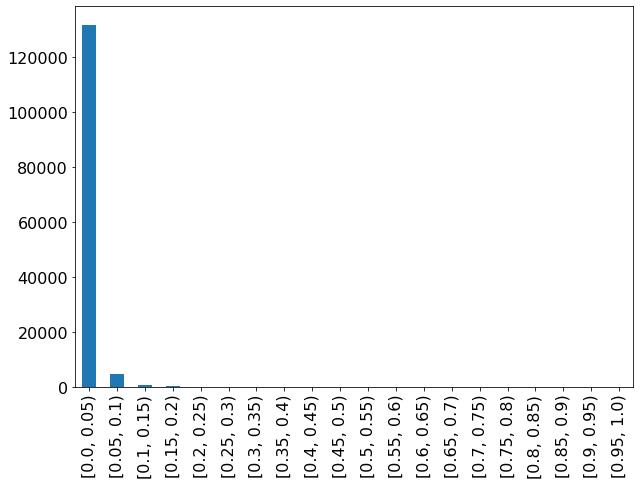

In [14]:
# do a histogram plot of the output variable "cap"
step = 0.05
bin_range = np.arange(0, 1+step, step)
out, bins  = pd.cut(df['cap'], bins=bin_range, include_lowest=True, right=False, retbins=True)
ax = out.value_counts(sort=False).plot.bar(figsize=(10,7), x="range", y="count")

In [15]:
# count number of caps in each bin
#  -- most of the caps are small and between 0 and 0.05
out.value_counts()

[0.0, 0.05)    131788
[0.05, 0.1)      4757
[0.1, 0.15)       580
[0.15, 0.2)       192
[0.2, 0.25)        52
[0.25, 0.3)        26
[0.35, 0.4)        21
[0.4, 0.45)        15
[0.3, 0.35)        13
[0.75, 0.8)         8
[0.8, 0.85)         8
[0.6, 0.65)         7
[0.7, 0.75)         7
[0.85, 0.9)         6
[0.45, 0.5)         6
[0.9, 0.95)         6
[0.55, 0.6)         4
[0.5, 0.55)         3
[0.65, 0.7)         3
[0.95, 1.0)         2
Name: cap, dtype: int64

## Correlation

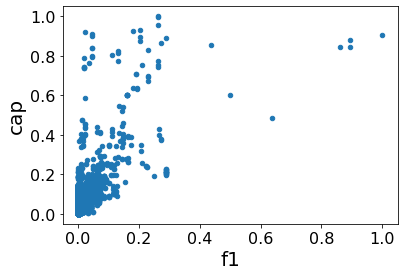

In [16]:
ax = df.plot(kind="scatter", x="f1", y="cap")

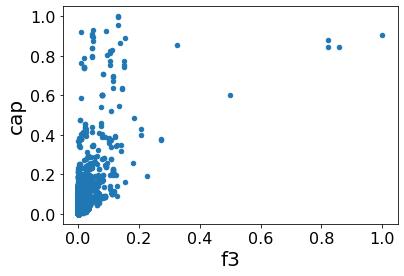

In [17]:
ax = df.plot(kind="scatter", x="f3", y="cap")

In [18]:
# Compute pairwise correlation of columns
corr_matrix = df.corr()

In [19]:
corr_matrix["cap"]

cap    1.000000
f1     0.622855
f2     0.111688
f3     0.539515
f4     0.364528
f5     0.423528
f6     0.323822
f7     0.455826
f8     0.423008
f9     0.455034
f10    0.038039
f11    0.422737
f12    0.479989
f13    0.542589
f14    0.421529
f15    0.311896
f16    0.396298
f17    0.003178
f18    0.000856
f19    0.028591
f20    0.620966
f21    0.613285
f22    0.562858
Name: cap, dtype: float64

# Prepare the Data For Machine Learning Algorithms

In [20]:
# output/target variable(s)
target_cols = ['cap']

# numerical attributes
num_attribs = ['f1','f2','f3','f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19',
       'f20', 'f21', 'f22']

# categorical attributes (we do not have any in this case)
cat_attribs = []

# get the meaningful attributes and target_cols in the dataframe called "circuit"
circuit = df[num_attribs+cat_attribs+target_cols].copy()

## Outliner Detection:  Use RANSAC (RANdom SAmple Consensus) algorithm.

In [21]:
def filter_outliers(X, Y, max_trials=500, sigma_scale=3):
    
    X_d = X.copy()
    Y_d = Y.copy()
    print("Length of Original data: ", len(X_d))
    min_samples = np.floor(len(X_d)/2)
    lmr = linear_model.RANSACRegressor(base_estimator=linear_model.LinearRegression(copy_X=True, normalize=True), 
                                       min_samples=min_samples, residual_threshold=sigma_scale*np.std([Y]), max_trials=max_trials, random_state=137)
    model = lmr.fit(X_d, Y)
    inlier_mask = lmr.inlier_mask_
    outlier_mask = np.logical_not(inlier_mask)

    X = X_d[inlier_mask].copy()
    Y = Y_d[inlier_mask].copy()

    print("Length of learing data: ", len(X))
    print("Percentage of original data: ", len(X)/len(X_d))
    print("Number of outliers found: ", len(X_d)-len(X))
    
    return X, Y
X = circuit[num_attribs+cat_attribs]
Y = circuit[target_cols]
X, Y = filter_outliers(X, Y)

Length of Original data:  137505
Length of learing data:  136607
Percentage of original data:  0.9934693283880586
Number of outliers found:  898


## Create Test and Train Data:

Before you do any training keep aside testing data -- humans are incredibly good at spotting patterns!! Just keep some data aside.

In [22]:
# Split X, Y into random train (X_train, Y_train) and test (X_test, Y_test) subsets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
print("Training Size: ", len(X_train), "Testing size: ", len(X_test))
print("#Features: ", len(X_train.columns))

Training Size:  95624 Testing size:  40983
#Features:  22


### Transformation Pipelines

In [23]:
# numerical pipeline object -- you may do data imputation here
#  -- we will do standard scaler transformation to our data
num_pipeline = Pipeline([('std_scaler', StandardScaler())])

# full pipeline with one-hot encoding of categorical inputs
full_pipeline = ColumnTransformer([
                ("num", num_pipeline, num_attribs),
                ("cat", OneHotEncoder(), cat_attribs),
                ])
X_train_prepared = full_pipeline.fit_transform(X_train)

# Explore Linear Regression, Random Forest (RF) and Gradient Boosted Decision Trees (GBDT)

### Helper function: RMSE function

In [24]:
# Root Mean Square Error function
def get_model_rmse(model, data_pipeline, X_test, Y_true):
    Y_pred = model.predict(data_pipeline.fit_transform(X_test))
    return np.sqrt(mean_squared_error(Y_true.to_numpy(), Y_pred))

### Default  Linear Regression  Model

In [25]:
%%time
# Ordinary least squares Linear Regression.
"""
LinearRegression fits a linear model with coefficients w = (w1, ..., wp)
to minimize the residual sum of squares between the observed targets in
the dataset, and the targets predicted by the linear approximation.
"""

lin_reg = LinearRegression()
lin_reg.fit(X_train_prepared, Y_train)
print("RMSE of default Linear Model: ", get_model_rmse(lin_reg, full_pipeline,  X_train, Y_train))

RMSE of default Linear Model:  0.012109838428412388
CPU times: user 284 ms, sys: 271 ms, total: 556 ms
Wall time: 165 ms


### Default Random Forest (RF) Regression 

In [26]:
%%time
# Random Forest Regressor
"""
A random forest is a meta estimator that fits a number of classifying
decision trees on various sub-samples of the dataset and uses averaging
to improve the predictive accuracy and control over-fitting.
"""
forest_reg = RandomForestRegressor(n_jobs=-1)
forest_reg.fit(X_train_prepared, Y_train.values)
print("RMSE of default RF Model: ",get_model_rmse(forest_reg, full_pipeline,  X_train, Y_train))

RMSE of default RF Model:  0.0033786973865209393
CPU times: user 30 s, sys: 295 ms, total: 30.3 s
Wall time: 7.78 s


### Default Gradient Boosted Decision Trees (GBDT)


In [27]:
%%time
#Gradient Boosting for regression.
"""
GB builds an additive model in a forward stage-wise fashion;
"""
gbdt_reg = GradientBoostingRegressor(random_state=0)
gbdt_reg.fit(X_train_prepared, Y_train.values)
print("RMSE of default GBDT Model: ",get_model_rmse(gbdt_reg, full_pipeline,  X_train, Y_train))

RMSE of default GBDT Model:  0.006332032559214701
CPU times: user 10.9 s, sys: 0 ns, total: 10.9 s
Wall time: 10.9 s


# Fine Tuning the model

## Evaluate Models using Cross-Validation: Compare CV_RMSE  scores with previously computed RMSE.

In [28]:
def display_cv_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

### CV Score of Linear Regression

In [29]:
scores = cross_val_score(lin_reg, X_train_prepared, Y_train, scoring = "neg_mean_squared_error", cv=5)
lin_rmse_scores = np.sqrt(-scores)
display_cv_scores(lin_rmse_scores)

Scores: [0.01328559 0.01195765 0.0121923  0.01214132 0.01212787]
Mean: 0.012340946430903676
Standard deviation: 0.00047887469420691375


### CV Score of Random Forest Regression

In [30]:
scores = cross_val_score(forest_reg, X_train_prepared, Y_train, scoring = "neg_mean_squared_error", cv=5)
forest_rmse_scores = np.sqrt(-scores)
display_cv_scores(forest_rmse_scores)

Scores: [0.00406476 0.00492766 0.00536735 0.00400481 0.00380739]
Mean: 0.0044343943083576965
Standard deviation: 0.0006046536760889458


### CV Score of GBDT

In [31]:
scores = cross_val_score(gbdt_reg, X_train_prepared, Y_train, scoring = "neg_mean_squared_error", cv=5)
gbdt_rmse_scores = np.sqrt(-scores)
display_cv_scores(gbdt_rmse_scores)

Scores: [0.00669476 0.00684345 0.00741301 0.00654892 0.00647032]
Mean: 0.006794091938922407
Standard deviation: 0.00033475310988066275


# Hyper Parameter Tuning

We discovered that Random Forest performs best on CV scores. Can we further imrove RF or GDBT using hyper-parameter tuning?

In [32]:
%%time

# Define a parameter grid and do hyperparameter tuning for RF model

""" 
param_grid = [
    {'n_estimators': [100], 'max_depth':[10,15,None]}, 
    ]
""" 
param_grid = [
    {'n_estimators': [50, 100, 150, 200],
     'max_depth':[10,15,None],
     'max_features': ["auto", "sqrt", "log2", None],
     'min_samples_leaf':[1, 5, 10, 15, 20]}  
    ]
forest_reg_gs = RandomForestRegressor(n_jobs=-1)

grid_search_forest = HalvingGridSearchCV(forest_reg_gs, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True, verbose=0, n_jobs=-1)

grid_search_forest.fit(X_train_prepared, Y_train)
print("Best RF estimator", grid_search_forest.best_estimator_)
print("RMSE of tuned RF model is :", get_model_rmse(grid_search_forest, full_pipeline, X_train, Y_train))

Best RF estimator RandomForestRegressor(max_features='sqrt', n_estimators=200, n_jobs=-1)
RMSE of tuned RF model is : 0.0033875927206198746
CPU times: user 27.1 s, sys: 270 ms, total: 27.4 s
Wall time: 6min 24s


In [33]:
%%time
# Define a parameter grid and do hyperparameter tuning for GBDT model
"""
param_grid = [
    {'n_estimators': [100], 'max_depth':[10,15,None]}, 
    ]
"""
param_grid = [
    {'n_estimators': [50, 100, 150, 200],
     'max_depth':[10,15,None],
     'max_features': ["auto", "sqrt", "log2", None],
     'min_samples_leaf':[1, 5, 10, 15, 20]}  
    ]
gbdt_reg_gs = GradientBoostingRegressor()

grid_search_gbdt = HalvingGridSearchCV(gbdt_reg_gs, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True, verbose=0, n_jobs=-1)

grid_search_gbdt.fit(X_train_prepared, Y_train)
print("Best GBDT estimator", grid_search_gbdt.best_estimator_)
print("RMSE of tuned GBDT model is ", get_model_rmse(grid_search_gbdt, full_pipeline, X_train, Y_train))

Best GBDT estimator GradientBoostingRegressor(max_depth=10, max_features='sqrt')
RMSE of tuned GBDT model is  0.003281195598028159
CPU times: user 15 s, sys: 780 ms, total: 15.8 s
Wall time: 4min 46s


### Quick Test

In [34]:
# plotting 
some_data = X_train.iloc[:5]
some_labels = Y_train.iloc[:5] 
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions       RF Model:", forest_reg.predict(some_data_prepared))
print("Predictions tuned RF Model:", grid_search_forest.predict(some_data_prepared))
print("Predictions       GBDT Model", gbdt_reg.predict(some_data_prepared))
print("Predictions tuned GBDT Model", grid_search_gbdt.predict(some_data_prepared))
print("Labels:      ", some_labels.transpose())

Predictions       RF Model: [0.00286248 0.00046561 0.00305074 0.00048138 0.07553159]
Predictions tuned RF Model: [0.00284831 0.00046582 0.00304563 0.00048168 0.0755103 ]
Predictions       GBDT Model [0.00945122 0.00063459 0.00372003 0.00144793 0.07204102]
Predictions tuned GBDT Model [0.00336014 0.00045715 0.00280984 0.00049241 0.07551923]
Labels:              131857    113303    55901     73260     1805  
cap  0.003023  0.000565  0.002592  0.000482  0.081947


### Tuned RF on Training Data

Text(0.5, 1.0, 'RF Predictions on Training Data')

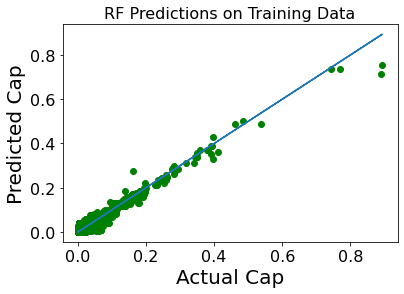

In [35]:
plt.scatter(Y_train, grid_search_forest.predict(X_train_prepared), color='g', label='Predictions')
plt.plot(Y_train, Y_train)
plt.xlabel("Actual Cap")
plt.ylabel("Predicted Cap")
plt.title("RF Predictions on Training Data")

### Tuned GBDT  on Training Data

Text(0.5, 1.0, 'GBDT Predictions on Training Data')

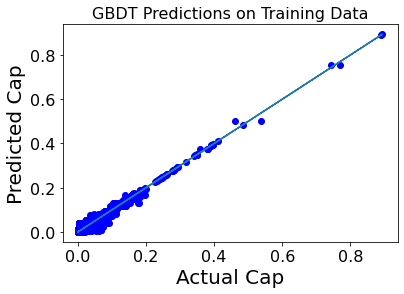

In [36]:
plt.scatter(Y_train, grid_search_gbdt.predict(X_train_prepared), color='b', label='Predictions')
plt.plot(Y_train, Y_train)
plt.xlabel("Actual Cap")
plt.ylabel("Predicted Cap")
plt.title("GBDT Predictions on Training Data")

# Final Test

In [37]:
# Final Test
### Random Forest Metrics on Test Data
final_model = grid_search_forest.best_estimator_
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
R2 = r2_score(Y_test, final_predictions)
print("R2 Score is : ", R2)
print("RMSE is:", get_model_rmse(grid_search_forest.best_estimator_, full_pipeline, X_test, Y_test))



R2 Score is :  0.9388278509745729
RMSE is: 0.006805427527653161


In [38]:
### GBDT Metrics on Test Data
final_model = grid_search_gbdt.best_estimator_
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
R2 = r2_score(Y_test, final_predictions)
print("R2 Score is : ", R2)
print("RMSE is:", get_model_rmse(grid_search_gbdt.best_estimator_, full_pipeline, X_test, Y_test))


R2 Score is :  0.8415378355758799
RMSE is: 0.0069953483921755


# Test Set Plotting

Text(0.5, 1.0, 'RF Predictions on Testing Data')

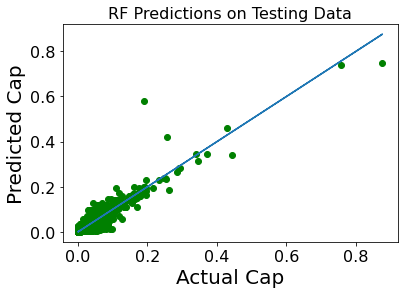

In [39]:
plt.scatter(Y_test, grid_search_forest.predict(X_test_prepared), color='g', label='Predictions')
plt.plot(Y_test, Y_test)
plt.xlabel("Actual Cap")
plt.ylabel("Predicted Cap")
plt.title("RF Predictions on Testing Data")

Text(0.5, 1.0, 'GBDT Predictions on Testing Data')

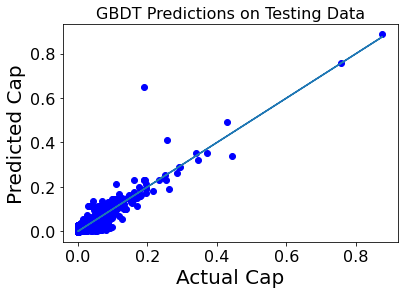

In [40]:
plt.scatter(Y_test, grid_search_gbdt.predict(X_test_prepared), color='b', label='Predictions')
plt.plot(Y_test, Y_test)
plt.xlabel("Actual Cap")
plt.ylabel("Predicted Cap")
plt.title("GBDT Predictions on Testing Data")

# Saving the Model

In [41]:
# Open the file to save as .p file
import pickle
model_file = "mlparest_model.p"
model_p = open(model_file, 'wb')
final_model = grid_search_forest.best_estimator_
final_model.feature_names = list(X.columns)
final_model.version = "1"
pickle.dump(final_model, model_p)
# Close the pickle instances
model_p.close()

# Test the saved model
with open(model_file, 'rb') as f:
    final_model_loaded = pickle.load(f)

### Testing on random data

In [42]:
test_input = np.random.rand(10,22)
output = final_model_loaded.predict(test_input)
print(output)

[0.02326333 0.02730569 0.0296529  0.02223501 0.02055186 0.02301419
 0.02914569 0.02222564 0.02484988 0.0221548 ]
